# [[데이콘] 영화 관객수 예측 모델 개발](https://dacon.io/competitions/open/235536/overview/description)

[평가 지표]
- RMSE

[Files]  
① movies_train.csv    
2010년대 한국에서 개봉한 한국영화 600개에 대한 감독, 이름, 상영등급, 관객수 등의 정보가 담긴 데이터  
② movies_test.csv  
관객수를 제외하고 movies_train과 동일  
③ submission.csv  
제출 파일의 형식


[Data fields]  
① movies_train.csv  
2010년대 한국에서 개봉한 한국영화 600개에 대한 감독, 이름, 상영등급, 관객수 등의 정보가 담긴 데이터

Column_name Description  
1 title : 영화의 제목  
2 distributor : 배급사  
3 genre : 장르  
4 release_time : 개봉일  
5 time : 상영시간(분)  
6 screening_rat : 상영등급  
7 director : 감독이름  
8 dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)  
9 dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)  
10 num_staff : 스텝수  
11 num_actor : 주연배우수  
12 box_off_num : 관객수  


③ submission.csv
제출 파일의 형식 



### step1. 필요한 패키지 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv('pydata/movies_train.csv')
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [3]:
test = pd.read_csv('pydata/movies_test.csv')
submission = pd.read_csv('pydata/submission.csv')

### step2. EDA

In [4]:
# train 데이터 기본 정보 확인
print(train.info())
print(train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB
None
(600, 12)


In [5]:
# train 데이터 셋 결측치 확인
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [6]:
# 수치형 변수의 기초통계량 확인
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


In [7]:
# dir_prev_bfnum 컬럼 결측치 대체
train.fillna(value=0, inplace=True)
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [8]:
# test 데이터 셋에서도 결측치가 있는지 확인
# isna()와 isnull()은 같은 함수이다.
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [9]:
# test 데이터 셋의 dir_prev_bfnum 컬럼 결측치 대체
test['dir_prev_bfnum'].fillna(value=0, inplace=True)
test.isnull().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64

#### **관람객 수가 가장 많은 10개 영화 목록**

In [10]:
train.sort_values(by='box_off_num', ascending=False).head(10)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
372,국제시장,CJ 엔터테인먼트,드라마,2014-12-17,126,12세 관람가,윤제균,0.000000e+00,0,869,4,14262766
362,도둑들,(주)쇼박스,느와르,2012-07-25,135,15세 관람가,최동훈,2.564692e+06,3,462,10,12983841
530,7번방의 선물,(주)NEW,코미디,2013-01-23,127,15세 관람가,이환경,8.190495e+05,2,300,8,12811435
498,암살,(주)쇼박스,액션,2015-07-22,139,15세 관람가,최동훈,5.169479e+06,4,628,3,12706663
460,"광해, 왕이 된 남자",CJ 엔터테인먼트,드라마,2012-09-13,131,15세 관람가,추창민,1.552541e+06,2,402,3,12323595
122,변호인,(주)NEW,드라마,2013-12-18,127,15세 관람가,양우석,0.000000e+00,0,311,5,11374879
496,설국열차,CJ 엔터테인먼트,SF,2013-08-01,125,15세 관람가,봉준호,0.000000e+00,0,67,10,9350351
101,관상,(주)쇼박스,드라마,2013-09-11,139,15세 관람가,한재림,1.242778e+06,2,298,6,9135806
505,해적: 바다로 간 산적,롯데엔터테인먼트,SF,2014-08-06,130,12세 관람가,이석훈,1.843895e+06,3,868,2,8666208
476,수상한 그녀,CJ 엔터테인먼트,코미디,2014-01-22,124,15세 관람가,황동혁,2.781990e+06,2,437,5,8659725


#### **영화 장르별 평균 관람객 수**

In [11]:
# 장르별로 내림차순
train[['genre', 'box_off_num']].groupby('genre').mean().sort_values(by='genre', ascending=False)

,box_off_num
genre,
코미디,1.193914e+06
액션,2.203974e+06
애니메이션,1.819267e+05
서스펜스,8.261100e+04
미스터리,5.275482e+05
뮤지컬,6.627000e+03
멜로/로맨스,4.259680e+05
드라마,6.256898e+05
다큐멘터리,6.717226e+04


#### **변수간 상관관계 파악(+ 히트맵)**

In [12]:
#상관분석은 숫자로 계산할 수 있으므로 데이터에서 숫자로 이루어진 컬럼만을 뽑는다
train_number = train.select_dtypes(np.number)

In [13]:
corr = train_number.corr()

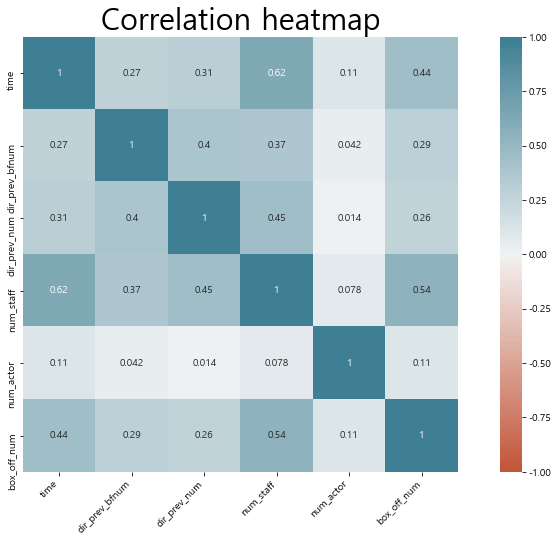

In [14]:
plt.colormap = plt.cm.PuBu
plt.figure(figsize=(15,8))
ax = sns.heatmap(
    corr, vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square = True, annot = True
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
    )

plt.title('Correlation heatmap', fontsize=30)
plt.show()

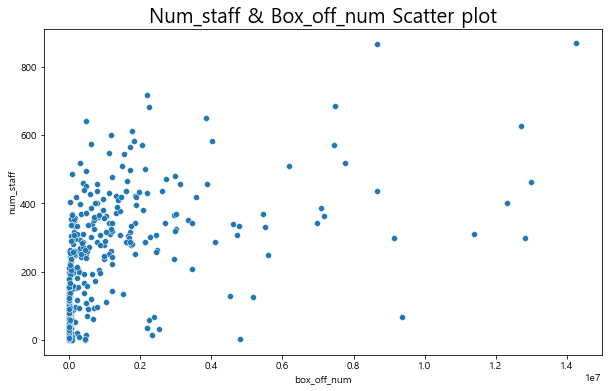

In [15]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=train, x='box_off_num', y='num_staff')
ax.set_title('Num_staff & Box_off_num Scatter plot', fontsize=20)
plt.show()

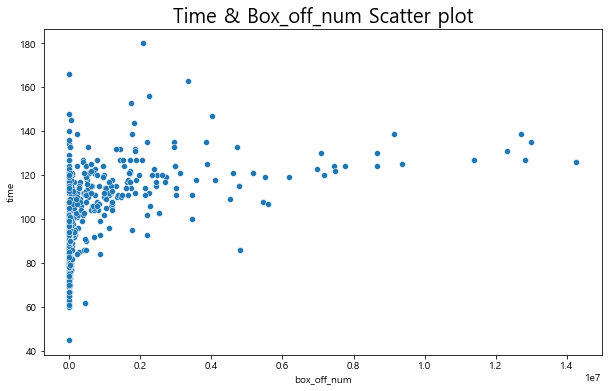

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=train, x='box_off_num', y='time')
ax.set_title('Time & Box_off_num Scatter plot', fontsize=20)
plt.show()

### step3. 예측 모델 생성

In [17]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, VotingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
import multiprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

In [20]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [23]:
# X, y 데이터 생성
X = train.drop(columns=['title', 'distributor', 'genre', 'director', 'release_time', 'screening_rat', 'box_off_num'])
y = train['box_off_num']

#### **LinearRegression & Ridge & Lasso**

In [39]:
# LinearRegression
# scale 전
linear_model = LinearRegression()
linear_model.fit(X, y)

predict = linear_model.predict(X)

print('[scale 전]')
print('모델 평가: {}'.format(linear_model.score(X, y)))
print('MSE: {}'.format(mean_squared_error(y, predict)))
print('RMSE: {}'.format(mean_squared_error(y, predict)**.5))
print('R2 score: {}'.format(r2_score(y, predict)))

# StandardScaler 
stand_scaler = StandardScaler()
X_scale1 = stand_scaler.fit_transform(X)

stand_model = LinearRegression()
stand_model.fit(X_scale1, y)

stand_predict = stand_model.predict(X_scale1)

print('\n[StandardScaler 후]')
print('모델 평가: {}'.format(stand_model.score(X_scale1, y)))
print('MSE: {}'.format(mean_squared_error(y, stand_predict)))
print('RMSE: {}'.format(mean_squared_error(y, stand_predict)**.5))
print('R2 score: {}'.format(r2_score(y, stand_predict)))

# MinMaxScaler 
MM_scaler = MinMaxScaler()
X_scale2 = MM_scaler.fit_transform(X)

MM_model = LinearRegression()
MM_model.fit(X_scale2, y)

MM_predict = MM_model.predict(X_scale2)

print('\n[MinMaxScaler 후]')
print('모델 평가: {}'.format(MM_model.score(X_scale2, y)))
print('MSE: {}'.format(mean_squared_error(y, MM_predict)))
print('RMSE: {}'.format(mean_squared_error(y, MM_predict)**.5))
print('R2 score: {}'.format(r2_score(y, MM_predict)))

[scale 전]
모델 평가: 0.3254871160422663
MSE: 2250199296732.611
RMSE: 1500066.4307731877
R2 score: 0.3254871160422663

[StandardScaler 후]
모델 평가: 0.3254871160422663
MSE: 2250199296732.611
RMSE: 1500066.4307731877
R2 score: 0.3254871160422663

[MinMaxScaler 후]
모델 평가: 0.32548711604226643
MSE: 2250199296732.6104
RMSE: 1500066.4307731877
R2 score: 0.32548711604226643


scale 전과 후가 똑같은 평가 점수를 보인다.